<a href="https://colab.research.google.com/github/Gus-1003/Antares/blob/main/2_segmentacao_objetos_pdi_roedores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/

Mounted at /content/drive/
/content/drive/MyDrive


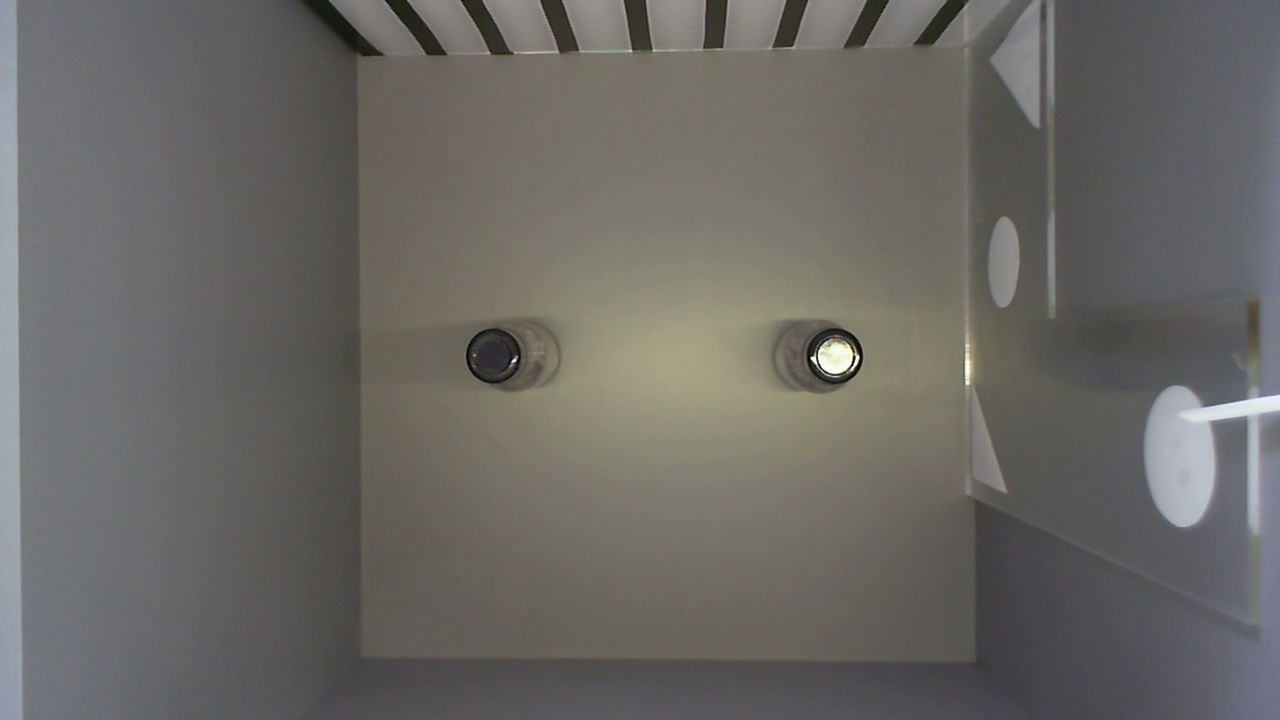

In [4]:
image = cv2.imread("/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp 35 - rodada 2 - analisados/result_antares/CCM247-TR-Contexto2DLC_resnet50_exp35-campo-cinzaJun5shuffle1_300000_labeled.jpg")
cv2_imshow(image)

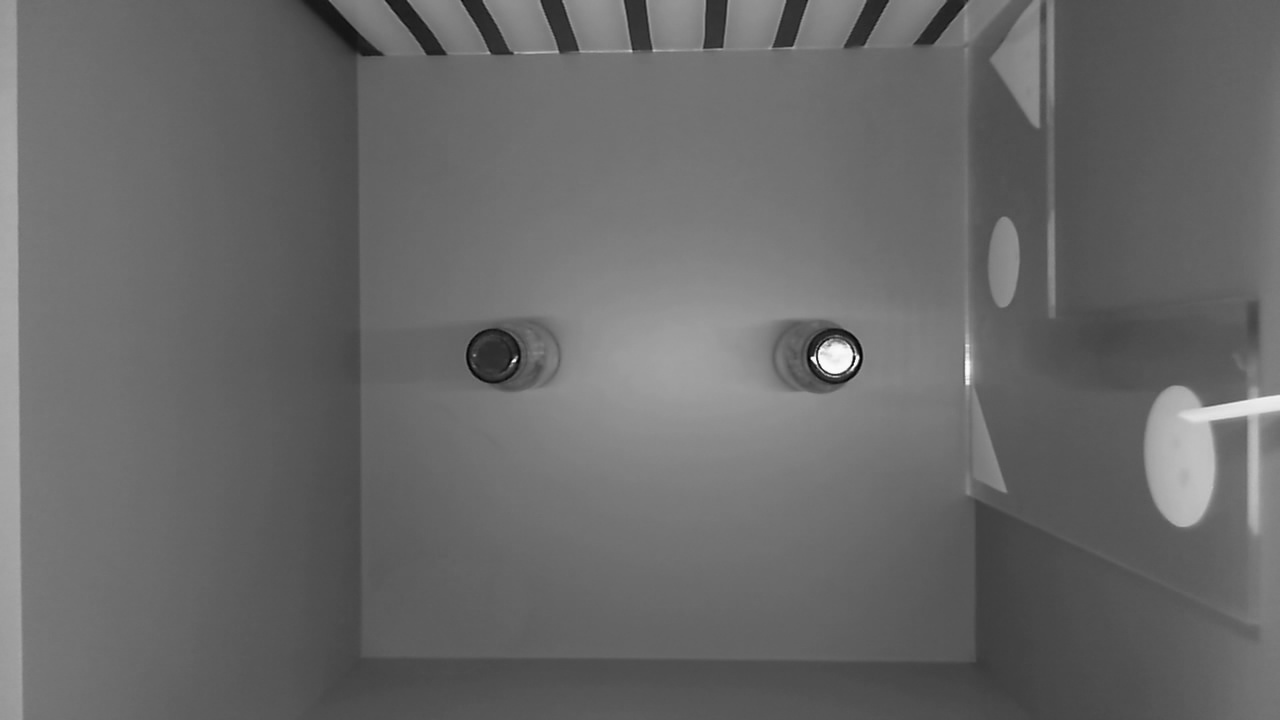

In [5]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

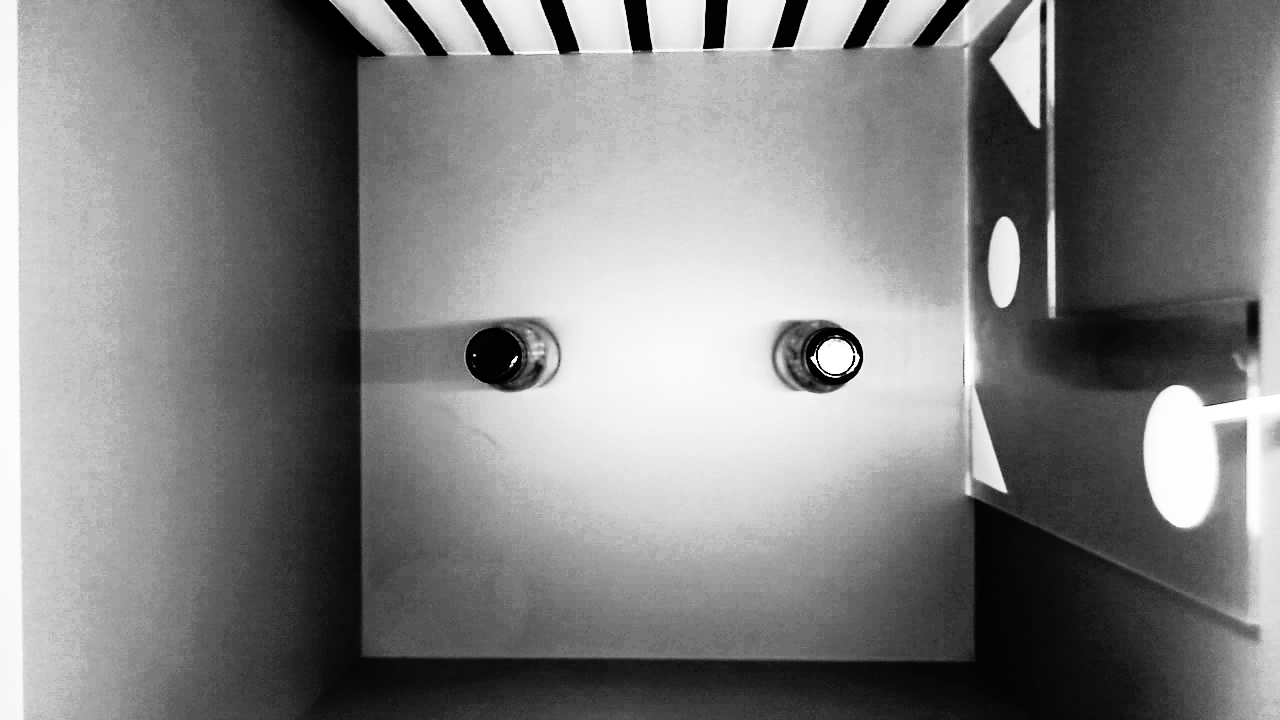

In [6]:
equalized_image = cv2.equalizeHist(gray_image)
cv2_imshow(equalized_image)

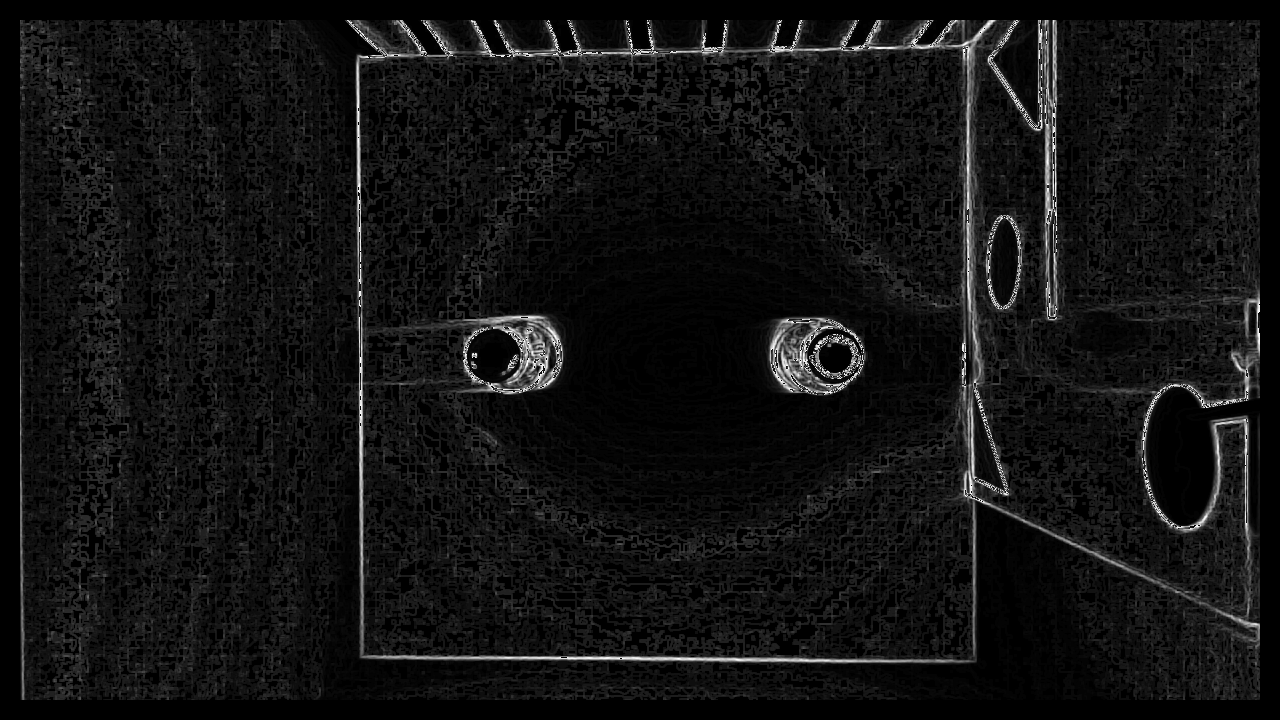

In [7]:
#image32f = np.float32(equalized_image)
image32f = np.float32(equalized_image)
mu = cv2.blur(image32f, (3, 3))
mu2 = cv2.blur(image32f * image32f, (3, 3))
sigma = cv2.sqrt(mu2 - mu * mu)
sigma = sigma * 10
sigma = sigma.astype("uint8")

sigma[:20, :] = 0
sigma[-20:, :] = 0
sigma[:, :20] = 0
sigma[:, -20:] = 0


cv2_imshow(sigma)

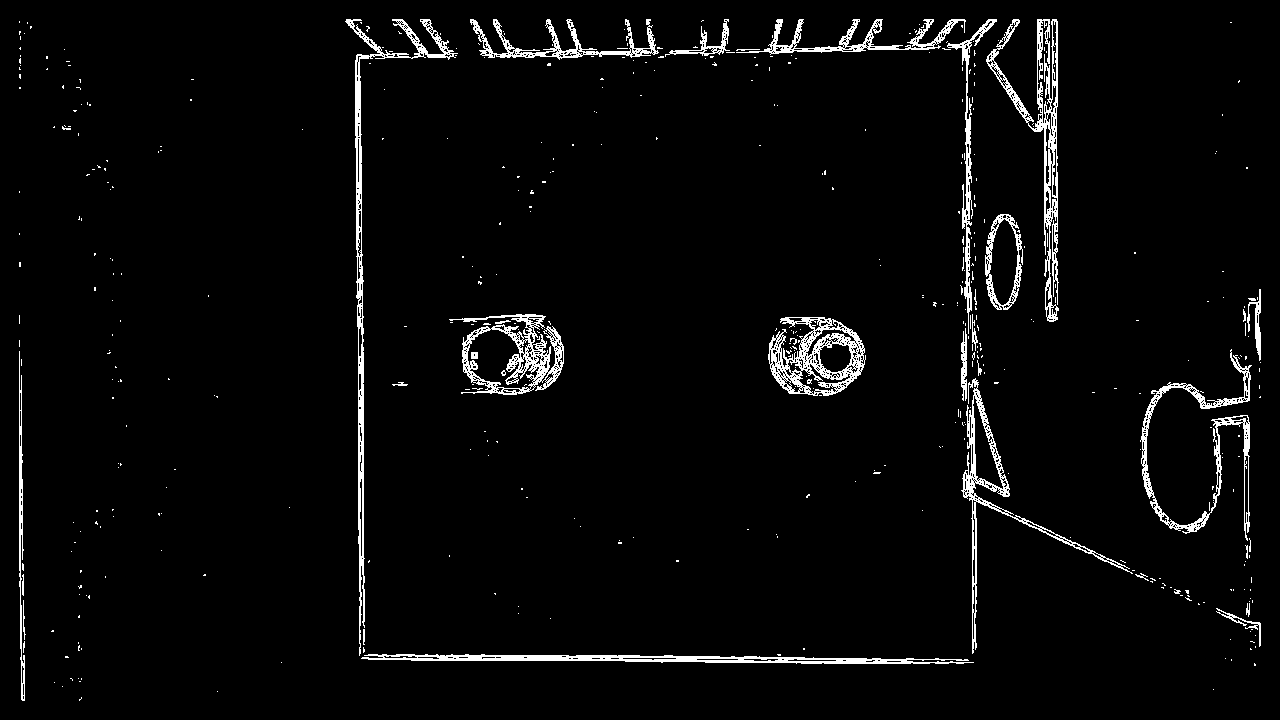

In [8]:
sobelx = cv2.Sobel(sigma, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(sigma, cv2.CV_64F, 0, 1, ksize=3)

# Calcula a magnitude do gradiente
gradient_magnitude = cv2.magnitude(sobelx, sobely)

# Normaliza a magnitude do gradiente
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Aplica uma limiarização utilizando o método de Otsu
_, gradient_threshold = cv2.threshold(gradient_magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(gradient_threshold)

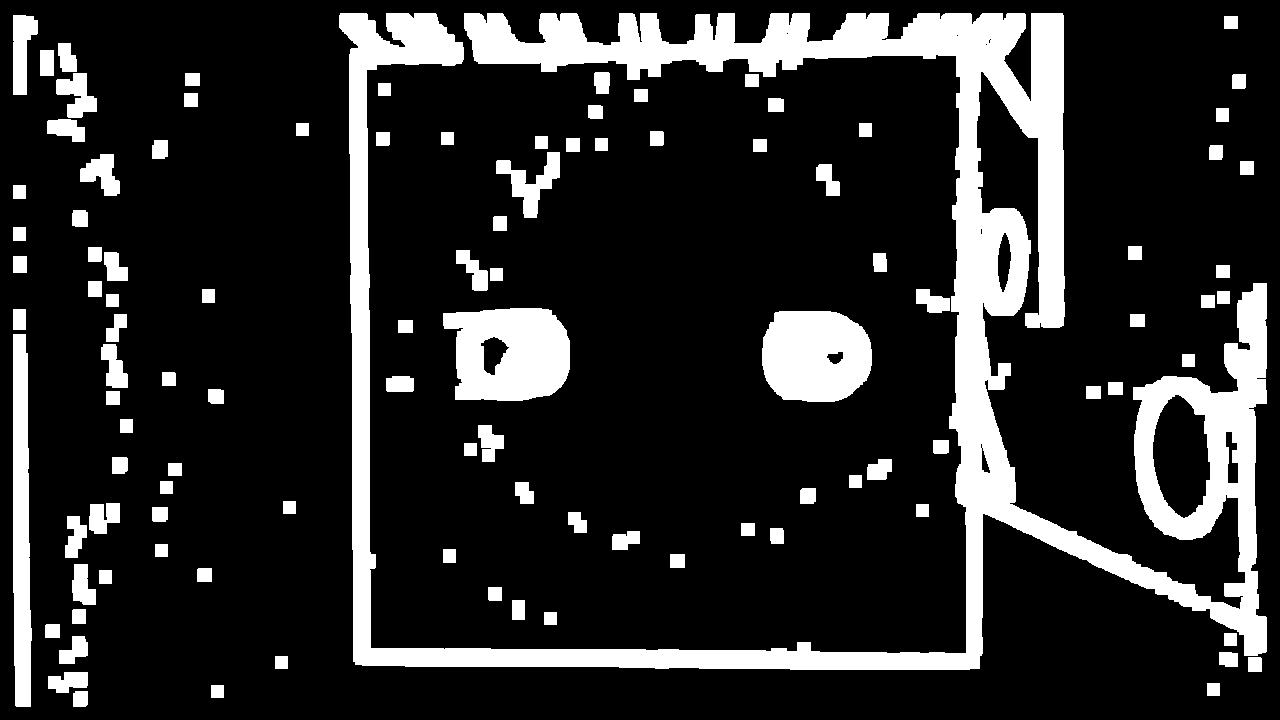

In [9]:
# Define o kernel para a dilatação
kernel = np.ones((5, 5), np.uint8)

# Dilata a imagem
dilate_image = cv2.dilate(gradient_threshold, kernel, iterations=3)
cv2_imshow(dilate_image)

In [10]:
contours, hierarchy = cv2.findContours(gradient_threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [11]:
def contour_properties(contour):
  """
  Computes various properties of a contour.

  Args:
      contour (numpy.ndarray): Input contour.

  Returns:
      tuple: Contour properties including area, circularity, radius, bounding box dimensions,
              aspect ratio, bounding box coordinates, and centroid coordinates.
  """
  import cv2
  import numpy as np

  # Calculate moments of the contour
  M = cv2.moments(contour)

  # Calculate area of the contour
  area = cv2.contourArea(contour)

  # Calculate perimeter of the contour
  perimeter = cv2.arcLength(contour, True)

  # Calculate bounding box dimensions and aspect ratio
  x, y, w, h = cv2.boundingRect(contour)
  aspect_ratio = max(float(w), h) / min(float(w), h) if min(w, h) > 0 else 0

  # Calculate minimum enclosing rectangle and circle
  rect = cv2.minAreaRect(contour)
  circle = cv2.minEnclosingCircle(contour)

  # Calculate rectangle coordinates and area
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  rect_area = w * h

  # Calculate centroid using different methods
  center_x = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
  center_y = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0

  # Calculate circularity of the contour
  circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0

  # Calculate circle properties
  (_, _), radius = cv2.minEnclosingCircle(contour)
  center_circle = (int(center_x), int(center_y))

  # Calculate square properties
  cx_quad = int(x)
  cy_quad = int(y)

  return (area, circularity, radius, x, y, w, h, aspect_ratio,
          box, center_circle, center_x, center_y)

In [12]:
def process_contours(frame_name, frame, contours, background):
    """
    Processes contours found in an image, categorizing them based on certain criteria.

    Args:
        frame_name (str): Name of the frame or image.
        frame (numpy.ndarray): Base image for drawing the contours.
        contours (list): List of contours found in the image.

    Returns:
        tuple: Tuple containing the processed image, object count, and dictionary of contour data.
    """
    import cv2

    object_count = 0
    contour_data = {}  # Dictionary to store data of identified objects

    previous_contour = None  # Variável para armazenar o contorno anteriormente escolhido
    previous_contour_area = 0  # Variável para armazenar a área do contorno anteriormente escolhido

    for contour in contours:
        # Approximate the contour with a sequence of line segments
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

        # Calculate contour properties
        area, circularity, radius, x, y, w, h, aspect_ratio, box, center_circle, cx_circle, cy_circle = contour_properties(contour)

        if background == 1:
            w += 20

        # Check if the contour matches a circular pattern
        if area > 2000 and 20 < radius < 100 and  100 < x < 800 and 150 < y < 400 and 80 < w < 160:

            # Limit the radius to a maximum value
            max_radius = 100
            radius = min(radius, max_radius)
            radius = int(radius)

            if radius < 80:
                radius += 30

            # Draw a circular contour
            cv2.circle(frame, center_circle, radius, (255, 0, 0), 2)

            # Draw the central point
            cv2.circle(frame, (cx_circle, cy_circle), 3, (255, 0, 0), -1)

            # Increment object count
            object_count += 1

            # Define the text to be written on the image
            text = f"Object{object_count}"

            # Coordinates where the text will be placed (top-left corner)
            coordinates = (cx_circle, cy_circle)

            # Specify the font and text size
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_size = 0.5
            color = (0, 0, 0)  # Text color in BGR (white in this example)

            # Add the text to the image
            image_with_text = cv2.putText(frame, text, coordinates, font, font_size, color, thickness=2)

            # Capture data
            contour_data[f"{frame_name}_{object_count}"] = [{
                "Form": "standard",
                "object": object_count,
                "Area": area,
                "Circularity": circularity,
                "Width": w,
                "Height": h,
                "X": cx_circle,
                "Y": cy_circle,
                "Radius": radius,
            }]

            # Verifica se o contorno atual contém o contorno anteriormente escolhido
            if previous_contour is not None and area > previous_contour_area:
                # Define o contorno atual como o contorno anteriormente escolhido
                previous_contour = contour
                previous_contour_area = area
            elif previous_contour is None:
                # Define o contorno atual como o contorno anteriormente escolhido
                previous_contour = contour
                previous_contour_area = area

    return frame, contour_data

In [13]:
background=1
image_name='teste'
results = process_contours(image_name, image, contours, background)

<ipython-input-11-86975b7890ae>:34: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [14]:
results[1]

{'teste_1': [{'Form': 'standard',
   'object': 1,
   'Area': 5253.5,
   'Circularity': 0.18764542956170516,
   'Width': 118,
   'Height': 79,
   'X': 818,
   'Y': 358,
   'Radius': 79}],
 'teste_2': [{'Form': 'standard',
   'object': 2,
   'Area': 5582.0,
   'Circularity': 0.07740058432291083,
   'Width': 135,
   'Height': 81,
   'X': 510,
   'Y': 356,
   'Radius': 91}],
 'teste_3': [{'Form': 'standard',
   'object': 3,
   'Area': 2409.0,
   'Circularity': 0.1528010771356488,
   'Width': 93,
   'Height': 62,
   'X': 497,
   'Y': 359,
   'Radius': 68}]}

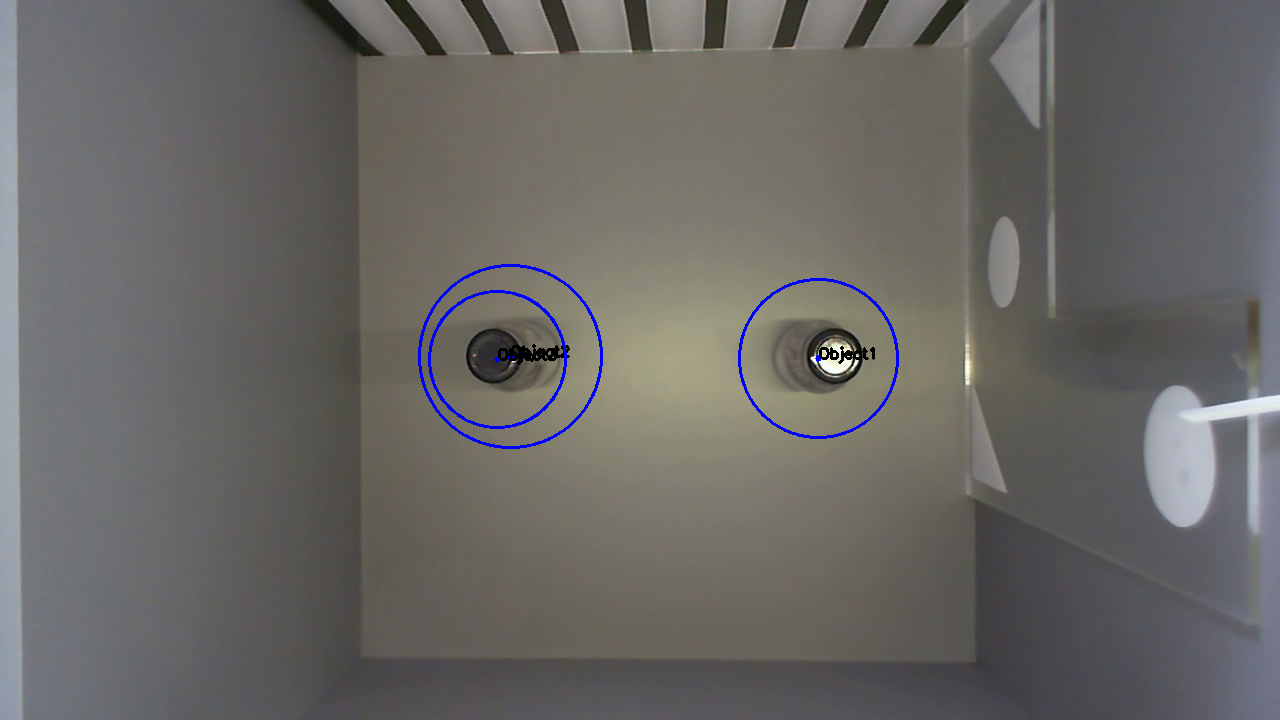

In [15]:
cv2_imshow(results[0])